In [12]:
from dotenv import dotenv_values
import httpx
from datetime import datetime
from dateutil.relativedelta import relativedelta
import json
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
def pretty_plot(df: pd.DataFrame, token_name: str):
    df.plot(x='timestamp', y='prices', kind='line')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Prices in USD')
    plt.title(label=f'Prices of {token_name} in USD')
    plt.show()

In [14]:
def pretty_plot_with_sma(df: pd.DataFrame, token_name: str):
    # Plot the dataframe with the SMA
    df.plot(x='timestamp', y=['prices', 'SMA'], kind='line')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Prices')
    plt.title(label=f'SMA of {token_name} in USD')
    plt.legend(['Prices', 'SMA'])
    plt.show()

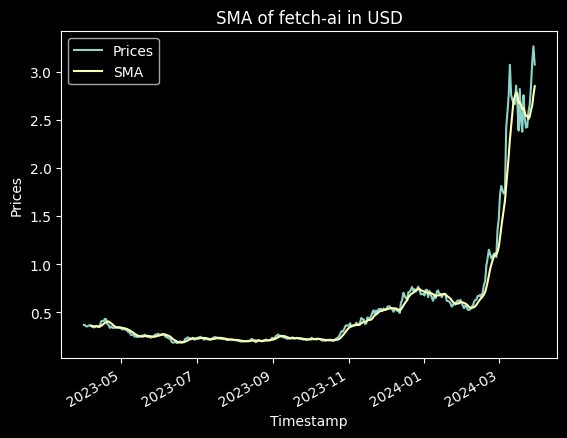

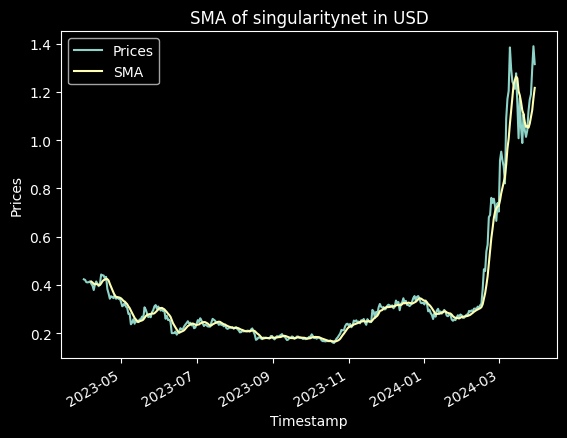

In [15]:

def write_json_to_file(data: dict):
    with open("tmp.json", "w") as f:
        json.dump(obj=data, fp=f, indent=4)


def get_unix_timestamps(delta_in_months: int = 1):
    now = datetime.now()
    requested_time = now - relativedelta(months=delta_in_months)

    now_unix = int(now.timestamp())
    requested_time_unix = int(requested_time.timestamp())

    return now_unix, requested_time_unix


def clean_data(data: dict, rolling_window: int = 30):
    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Process each category in the JSON data
    for key in data.keys():
        # Convert the data into a temporary DataFrame
        temp_df = pd.DataFrame(data[key], columns=['timestamp', key])
        
        # If our main DataFrame is empty, start it with this category's DataFrame
        if df.empty:
            df = temp_df
        else:
            df = pd.merge(left=df, right=temp_df, on='timestamp', how='outer')
    df['timestamp'] = pd.to_datetime(arg=df['timestamp'], unit='ms')
    df['SMA'] = df['prices'].rolling(window=rolling_window).mean()
    
    return df


def main(token: str):
    api = dotenv_values(dotenv_path=".env")["API_KEY"]
    params = {
        'vs_currency': 'usd',
        'days': '365',
        'interval': 'daily',
        'precision': 'full',
        'x_cg_demo_api_key': api,
    }
    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart"
    session = httpx.Client()
    response = session.get(url=url, params=params)
    data = clean_data(data=response.json(), rolling_window=7)
    pretty_plot_with_sma(df=data, token_name = token)
    return data
    

if __name__ == "__main__":
    df_fetch = main(token="fetch-ai")
    df_agix = main(token="singularitynet")

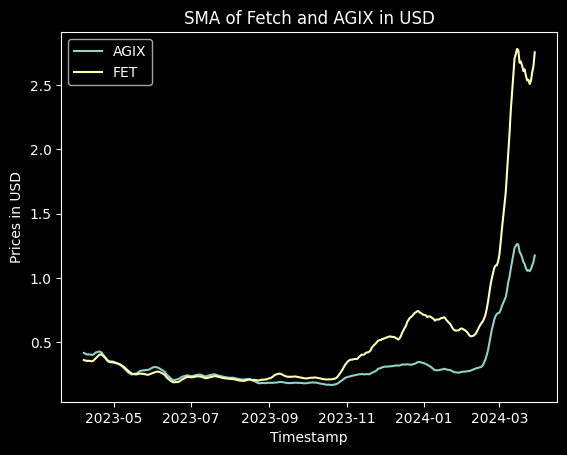

In [16]:
df_merged = pd.merge(left=df_agix, right=df_fetch, on='timestamp', suffixes=('_agix', '_fetch'))
plt.plot(df_merged['timestamp'], df_merged['SMA_agix'], label='AGIX')
plt.plot(df_merged['timestamp'], df_merged['SMA_fetch'], label='FET')
plt.xlabel(xlabel='Timestamp')
plt.ylabel(ylabel='Prices in USD')
plt.title(label="SMA of Fetch and AGIX in USD")
plt.legend()
plt.show()


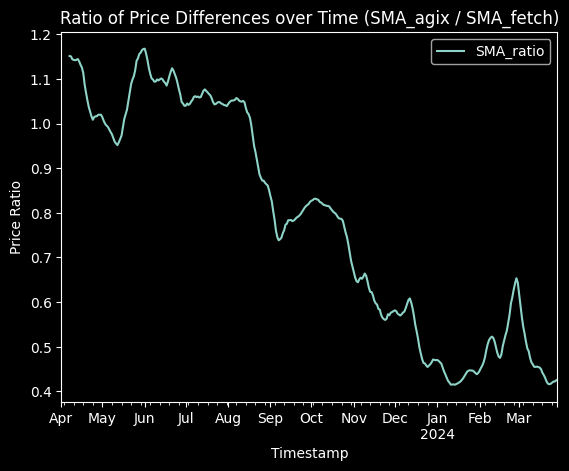

In [17]:
df_merged['SMA_ratio'] = df_merged['SMA_agix']/ df_merged['SMA_fetch']  
df_merged.plot(x='timestamp', y='SMA_ratio', kind='line')
plt.xlabel(xlabel='Timestamp')
plt.ylabel(ylabel='Price Ratio')
plt.title(label='Ratio of Price Differences over Time (SMA_agix / SMA_fetch)')
plt.show()

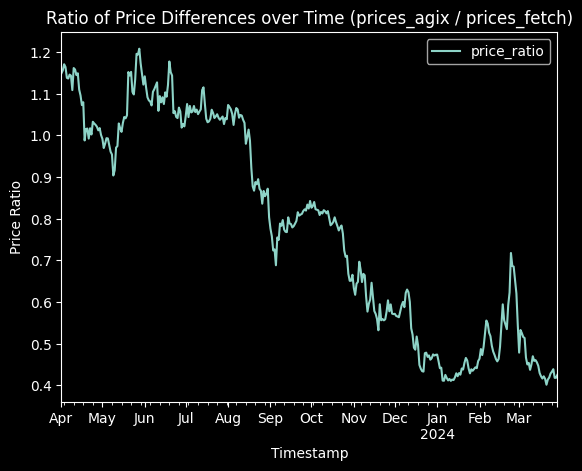

In [18]:
df_merged['price_ratio'] = df_merged['prices_agix']/ df_merged['prices_fetch']  
df_merged.plot(x='timestamp', y='price_ratio', kind='line')
plt.xlabel(xlabel='Timestamp')
plt.ylabel(ylabel='Price Ratio')
plt.title(label='Ratio of Price Differences over Time (prices_agix / prices_fetch)')
plt.show()

In [19]:
import numpy as np
average_price_ratio = df_merged['price_ratio'].mean()
average_sma_ratio = df_merged['SMA_ratio'].mean()
print(f"average SMA ratio: {average_sma_ratio}")
print(f"average_price_ratio: {average_price_ratio}")
# Our current weighting is 1:0.4333 FETCH:AGIX


average SMA ratio: 0.7807405514335561
average_price_ratio: 0.7814725998000375


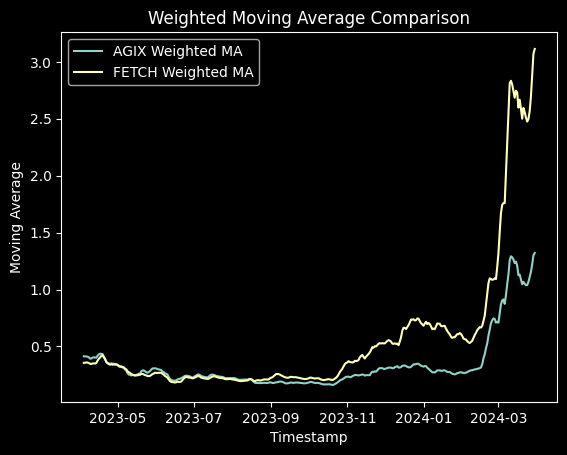

average Weighted moving average ratio: 0.7801525018914302


In [22]:
# 0-3 months : 40%
# 3-6 months : 30%
# 6-9 months : 20%
# 9-12 months : 10% 


def weighted_moving_average(data: pd.Series, weights: list) -> pd.Series:
    weighted_ma = data.rolling(window=len(weights)).apply(func=lambda x: np.dot(x, weights), raw=True)
    return weighted_ma

# Example usage
weights = [0.1, 0.2, 0.3, 0.4]
agix_weighted_ma = weighted_moving_average(data=df_agix['prices'], weights=weights)
fetch_weighted_ma = weighted_moving_average(data=df_fetch['prices'], weights=weights)


# Plot the moving average
plt.plot(df_agix['timestamp'], agix_weighted_ma, label='AGIX Weighted MA')
plt.plot(df_fetch['timestamp'], fetch_weighted_ma, label='FETCH Weighted MA')
plt.xlabel(xlabel='Timestamp')
plt.ylabel(ylabel='Moving Average')
plt.title(label='Weighted Moving Average Comparison')
plt.legend()
plt.show()


df_merged['weighted_SMA_ratio'] = agix_weighted_ma/fetch_weighted_ma
average_weighted_ma_ratio = df_merged['weighted_SMA_ratio'].mean()
print(f"average Weighted moving average ratio: {average_weighted_ma_ratio}")